# Vehicle Detection - Project 5

## Goals:
1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.

    1a. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

    Note: Don't forget to normalize your features and randomize a selection for training and testing.

2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
3. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
4. Estimate a bounding box for vehicles detected.

### Import Statements

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from hog_helper_functions import *

In [2]:
import sklearn
sklearn.__version__

'0.18.1'

### Goal 1: Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.

### Exploring the data : 


In [3]:
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')
print("Size of cars dataset : ", len(cars))
print("Size of non-cars dataset : ", len(notcars) )

Size of cars dataset :  8792
Size of non-cars dataset :  8968


### The size of the two data groups are approximately equal so balancing them is not required. 

In [4]:
# Exploring an arbitrary image
some_img = mpimg.imread("data/vehicles/GTI_Right/image0973.png")
print("Image shape : ", some_img.shape)
print("Image type : ", some_img.dtype)
print ("Max image value : {} ; Min image value : {} ; Mean image value : {}".format(np.max(some_img), 
                                                                                    np.min(some_img),
                                                                                    np.mean(some_img)))

Image shape :  (64, 64, 3)
Image type :  float32
Max image value : 1.0 ; Min image value : 0.05882352963089943 ; Mean image value : 0.3787945806980133


### Parameters : 

In [5]:
color_space='YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb ### YCrCb best so far
spatial_size=(16, 16) ### 16,16 best so far
hist_bins=16 ### 16 best so far
orient=9 ### 9 best so far
pix_per_cell=8 ### 8 best so far
cell_per_block=2 ### 2 best so far
hog_channel='ALL' # Can be 0, 1, 2, or "ALL" ### ALL best so far
spatial_feat=True ### T
hist_feat=True ### T
hog_feat=True ### T

### Extract features, create dataset

In [6]:
t1 = time.time() 
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

## Done
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
#!!! Further normalization, or is this enough? 
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=13)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell, and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

105.24 Seconds to extract HOG features...
Using: 9 orientations, 8 pixels per cell, and 2 cells per block
Feature vector length: 6108


### Applying an SVM classifier to the datasets

In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

33.81 Seconds to train SVC...


In [8]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.
  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.
  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.]
For these 100 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.
  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.
  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.]
0.02185 Seconds to predict 100 labels with SVC


### Goal 1 completed: Test accuracy of SVM classifier is 0.9887 in detecting images of cars vs non-cars. 
#### Now that our classifier can recognize cars, we process car-camera images by examining convolutions or windows, and classify those as cars or not. 

### Goal 2: Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

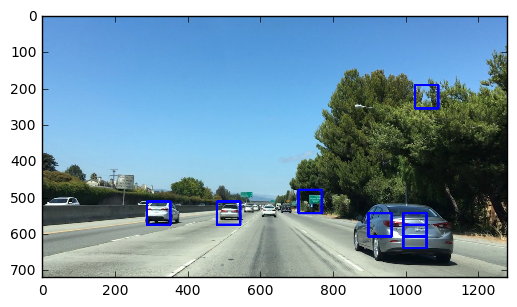

In [9]:
# parameters
x_start_stop = [None, None] # one diagonal of the rectangle to search within. Default is (0,0) to select the whole image.
y_start_stop = [None, None] # one diagonal of the rectangle to search within. Default is (0,0) to select the whole image.
xy_window = (64, 64)
xy_overlap = (0.5, 0.5)

image = mpimg.imread('examples/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255.

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()



### Goal 2 implemented:
The function slide_window feeds in portions of the image into our classifier. The first iteration produced a classifier with 0.9741 accuracy, but with extremely low specificity; it produced almost all windows as false positives, covering most of the image. 
After some parameter tuning, the accuracy has risen to 0.9887 and now the detection is significantly better. However, it still produces false positives and false negatives. 

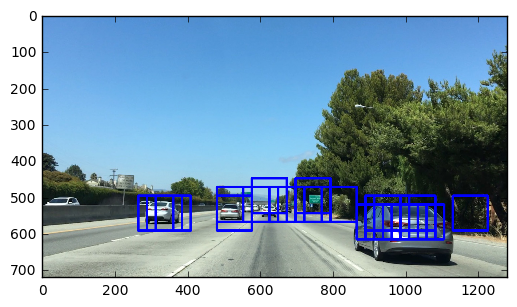

In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255.
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list
    
ystart = 400
ystop = 656
scale = 1.5
img = mpimg.imread('examples/bbox-example-image.jpg')
    
out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

In [11]:
for box in box_list:
    print(box)
    print (box[0][1], box[1][1])
    break

((264, 496), (360, 592))
496 592


In [12]:
detected_bboxes_in_img = []
frame_ctr = 0

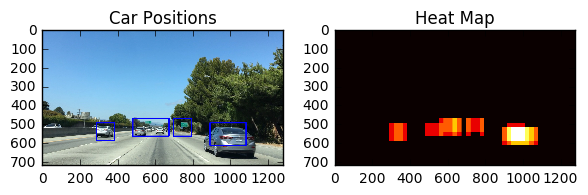

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('examples/bbox-example-image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def is_approx_equal(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    if (abs(x1 - x2) <= 50) and (abs(y1-y2) <= 50):
        return True
    else:
        return False

def is_true_positive(bbox):
    global detected_bboxes_in_img
    for box in detected_bboxes_in_img:
        if is_approx_equal(bbox[0], box[0]) and is_approx_equal(bbox[1], box[1]):
            return True
    return False    

def draw_labeled_bboxes(img, labels):
    global detected_bboxes_in_img
    global frame_ctr
    bboxes_in_img = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #print("labels[0] ", labels[0])
        #print("car number ", car_number)
        #print ("nonzero ", nonzero[0].shape, nonzero[1].shape)
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if len(detected_bboxes_in_img) != 0: #we'll start comparing only on the 11th frame onward
            if is_true_positive(bbox): # stub True
                bboxes_in_img.append(bbox)
                # Draw the box on the image
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        else:
            bboxes_in_img.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    # Return the image
    detected_bboxes_in_img = bboxes_in_img
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
#print("labels is ", labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()


In [14]:
detected_bboxes_in_img

[((480, 472), (671, 567)),
 ((696, 472), (791, 567)),
 ((288, 496), (383, 591)),
 ((888, 496), (1079, 615))]

### Goal 3 & 4 part I implemented. Bounding boxes and tresholding false positives has been implemented in the pipeline above. 

###  Goal 3 & 4 part II : Creating the final video pipeline

In [15]:
def vehicle_det_pipeline_v1(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255.

    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img

In [16]:
def vehicle_det_pipeline_v2(image):
    global frame_ctr
    global svc
    global X_scaler
    global orient
    global pix_per_cell
    global cell_per_block
    global spatial_size
    global hist_bins
    global detected_bboxes_in_img
    ystart = 400
    ystop = 656
    scale = 1.5
    frame_ctr += 1
    out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(vehicle_det_pipeline_v2) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [11:54<00:00,  2.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 9min 58s, sys: 41 s, total: 10min 39s
Wall time: 11min 55s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))